**временные ряды, модели регрессии, извлечение признаков**

Евгений Борисов <esborisov@sevsu.ru>

-----

Дмитрий Макаров   Временные ряды.    
https://www.dmitrymakarov.ru/intro/time-series-20/

Евгений Рябенко Прогнозирование временных рядов.     
https://www.youtube.com/watch?v=u433nrxdf5k



How To Create Time Series Features with tsfresh    
https://www.rasgoml.com/feature-engineering-tutorials/how-to-create-time-series-features-with-tsfresh`

-----

#  загружаем данные

In [1]:
import numpy as np
from numpy import random as rng
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
# Data from Google Finance

from pandas_datareader.data import DataReader
df = DataReader("AAPL", "stooq")
# df = DataReader("GS", "stooq") 
#df = DataReader("IBM", 'stooq')
df = df.reset_index()[['Date','Close']].rename(columns={'Close':'values','Date':'date'})
df = df.set_index('date').sort_index()

# df = df['values'].rolling(window=7*4).mean().dropna().to_frame().sort_index()

In [13]:
# # monthly totals of a US airline passengers from 1949 to 1960
# # 
# # AirPassengers.csv :
# #    https://drive.google.com/file/d/1yfw6gcgmJXCtxkjC69ekUvsEtAiYTlST/view?usp=share_link
# #    https://huggingface.co/spaces/Anniek/Time_series_forecast/raw/main/AirPassengers.csv

# url = 'https://huggingface.co/spaces/Anniek/Time_series_forecast/raw/main/AirPassengers.csv'
# df = pd.read_csv(url).convert_dtypes()

# df['date'] = pd.to_datetime(df['Month'])
# df = df.set_index('date')
# df = df.asfreq('MS')
# df = df[['#Passengers']].rename(columns={'#Passengers':'values'})
# df = df.sort_index()

In [14]:
display(len(df))
display(df.sample(3))

1258

,values
date,
2024-03-13,171.130
2022-03-28,174.807
2023-12-08,195.710


# анализ данных

__1. визуальная оценка данных__

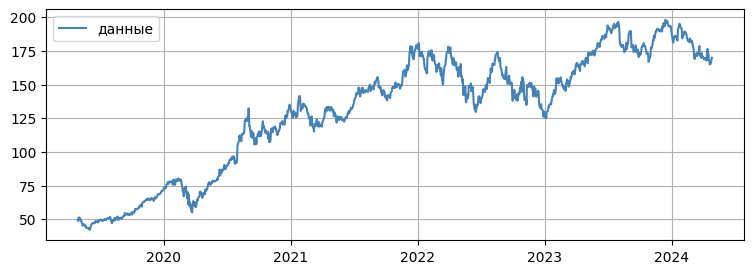

In [15]:
fig,ax = plt.subplots(figsize = (9,3))
ax.plot(df['values'], label = 'данные', color = 'steelblue')
# ax.plot(df['values'].rolling(window=12).mean(), label = 'скользящее среднее', color = 'red')
ax.legend(title = '', loc = 'upper left', )
ax.grid()

__оценка автокорреляции__

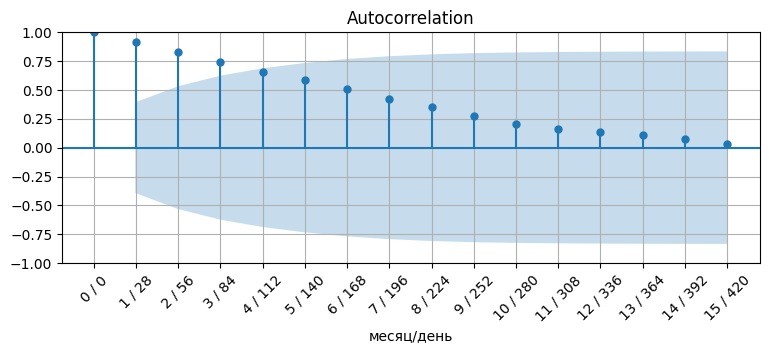

In [17]:
from statsmodels.graphics.tsaplots import plot_acf

lag_step = 7*4 # N дней
n_lags = 16 

lags = [ n for n in range(0,lag_step*n_lags,lag_step) ]

fig,ax = plt.subplots(figsize = (9,3))
plot_acf(df['values'],lags=lags,ax=ax,)
ax.set_xticks(lags)
# ax.set_xticklabels( list( map(str,range(n_lags)) ) )
ax.set_xticklabels([ f'{n} / {l}' for n,l in enumerate(lags) ]  )
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('месяц/день')
ax.grid()

# собираем датасет

In [18]:
display( df.index.min(), df.index.max(), )

Timestamp('2019-04-29 00:00:00')

Timestamp('2024-04-25 00:00:00')

In [19]:
# df_train, df_test = df[:'1958-12'],df['1959-01':]
df_train, df_test = df[:'2023-12'],df['2024-01':]

In [20]:
assert len(df_train)>2
assert len(df_test)>2

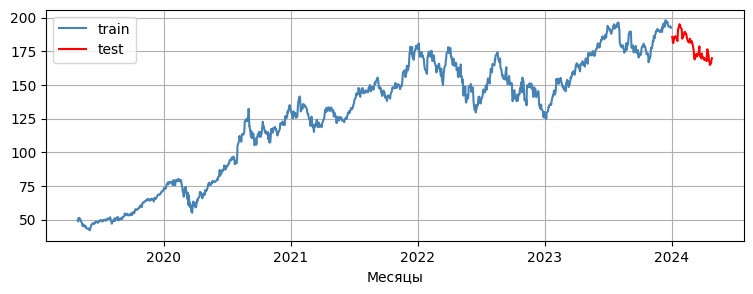

In [21]:
fig,ax = plt.subplots(figsize = (9,3))
ax.plot(df_train['values'], label = 'train', color = 'steelblue')
ax.plot(df_test['values'], label = 'test', color = 'red')
ax.set_xlabel('Месяцы', )
ax.legend(title = '', loc = 'upper left', )
ax.grid()

---

In [22]:
import tsfresh
from tsfresh.utilities import dataframe_functions as F

модель “плавающего окна”,    
для каждого значения формируем  историю предыдущих значений,     
из этой истории строим признаки   

In [23]:
# размер окна, по которому будем строить прогноз
history_deep = 7*4 # дней

In [24]:
# собираем последовательности значений размера history_deep
df_train.loc[:,'id'] = 0 # метка последовательности
df_train_roll = F.roll_time_series(
        df_train.reset_index().sort_values('date'),
        column_id='id', 
        column_sort='date',
        #column_value='values',
        min_timeshift=history_deep,
        # max_timeshift=history_deep, 
        # rolling_direction=1,
        # show_warnings=False,
        disable_progressbar=True,
        n_jobs=4,
    )

# метка группы
df_train_roll.loc[:,'id'] =  pd.to_datetime( df_train_roll['id'].str[1] )

# выкидываем последнюю группу, она остаётся без target при сдвиге
df_train_roll = df_train_roll[ df_train_roll['id']!= df_train_roll['id'].max() ]

display( df_train_roll.head(15))

/tmp/ipykernel_3293478/1816887245.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:,'id'] = 0 # метка последовательности
/opt/venv/sevgu_1/lib/python3.11/site-packages/tsfresh/utilities/dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(


,date,values,id
0,2019-04-29,49.5827,2019-06-07 00:00:00
1,2019-04-30,48.6276,2019-06-07 00:00:00
2,2019-05-01,51.0174,2019-06-07 00:00:00
3,2019-05-02,50.6834,2019-06-07 00:00:00
4,2019-05-03,51.3125,2019-06-07 00:00:00
5,2019-05-06,50.5179,2019-06-07 00:00:00
6,2019-05-07,49.1601,2019-06-07 00:00:00
7,2019-05-08,49.1670,2019-06-07 00:00:00
8,2019-05-09,48.6406,2019-06-07 00:00:00
9,2019-05-10,47.9667,2019-06-07 00:00:00


In [25]:
target_train = df_train.iloc[history_deep:]['values'].shift(-1).dropna()
display(target_train)

date
2019-06-07     46.8471
2019-06-10     47.3865
2019-06-11     47.2369
2019-06-12     47.2300
2019-06-13     46.8870
                ...   
2023-12-21    193.6000
2023-12-22    193.0500
2023-12-26    193.1500
2023-12-27    193.5800
2023-12-28    192.5300
Name: values, Length: 1149, dtype: float64

In [26]:
%%time 

# обрабатываем последовательности, извлекаем из них признаки

# # все признаки
# df_train_features = tsfresh.extract_features(
#     df_train_roll.reset_index(), 
#     column_id='id', 
#     column_sort='date', 
#     column_value='values',
# )

# # минимальный набор признаков
# df_train_features = tsfresh.extract_features(
#     df_train_roll.reset_index(), 
#     column_id='id', 
#     column_sort='date', 
#     column_value='values',
#     default_fc_parameters=tsfresh.feature_extraction.MinimalFCParameters()
# )


# отбор признаков релевантных c target 
df_train_features = tsfresh.extract_relevant_features(
        df_train_roll.reset_index(), 
        target_train,
        column_id='id',
        column_sort='date',
        column_value='values',
        show_warnings=False,
        disable_progressbar=False,
        n_jobs=4,
    )

# выкидываем признаки с пропусками
df_train_features = df_train_features.dropna(axis=1)

# сохраняем парамеры feature extractor для применения на test
feature_settings =  tsfresh.feature_extraction.settings.from_columns(df_train_features)
feature_order = df_train_features.columns # порядок признаков

display( len(df_train_features) ) # количество примеров
display( len(feature_order) ) # количество признаков
display( list(feature_order) ) # список признаков

display( df_train_features.sample(3) )

Feature Extraction: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:21<00:00,  7.05s/it]


1149

667

['values__sum_values',
 'values__number_peaks__n_3',
 'values__number_peaks__n_1',
 'values__number_cwt_peaks__n_5',
 'values__number_cwt_peaks__n_1',
 'values__fft_aggregated__aggtype_"centroid"',
 'values__fft_aggregated__aggtype_"variance"',
 'values__range_count__max_1000000000000.0__min_0',
 'values__max_langevin_fixed_point__m_3__r_30',
 'values__linear_trend__attr_"stderr"',
 'values__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"',
 'values__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"',
 'values__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"',
 'values__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"',
 'values__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"',
 'values__quantile__q_0.9',
 'values__quantile__q_0.8',
 'values__quantile__q_0.7',
 'values__number_peaks__n_5',
 'values__number_peaks__n_10',
 'values__fft_coefficient__attr_"imag"__coeff_1',
 'values__fft_coefficient__attr_"abs"__coeff_16',
 'values__fft_coe

,values__sum_values,values__number_peaks__n_3,values__number_peaks__n_1,values__number_cwt_peaks__n_5,values__number_cwt_peaks__n_1,"values__fft_aggregated__aggtype_""centroid""","values__fft_aggregated__aggtype_""variance""",values__range_count__max_1000000000000.0__min_0,values__max_langevin_fixed_point__m_3__r_30,"values__linear_trend__attr_""stderr""",...,"values__fft_coefficient__attr_""real""__coeff_27","values__fft_coefficient__attr_""real""__coeff_7","values__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.6","values__fft_coefficient__attr_""real""__coeff_6",values__ratio_beyond_r_sigma__r_3,"values__fft_coefficient__attr_""real""__coeff_20","values__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""max""","values__fft_coefficient__attr_""angle""__coeff_8","values__fft_coefficient__attr_""real""__coeff_11","values__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""min"""
2023-12-12 00:00:00,147886.7142,113.0,301.0,110.0,92.0,56.190919,14525.993426,1166.0,305.259501,0.001464,...,-64.727629,1817.730339,0.105287,-1040.550084,0.0,-610.824478,6.043049,60.242000,1111.671325,0.583729
2021-07-14 00:00:00,50222.2102,51.0,152.0,52.0,46.0,28.114731,3509.190002,558.0,130.560662,0.002318,...,-89.376025,-426.385971,0.166713,8.854873,0.0,175.737430,9.631941,72.068339,144.955540,0.921432
2021-11-11 00:00:00,62666.6442,62.0,174.0,62.0,50.0,29.640982,4287.230412,643.0,139.358750,0.001813,...,-85.735200,32.712934,0.072490,196.782680,0.0,-277.174681,9.370797,116.821059,-428.082678,0.903187


CPU times: user 3.54 s, sys: 346 ms, total: 3.89 s
Wall time: 2min 23s


In [27]:
# извлекаем признаки из test

# собираем последовательности значений размера history_deep
df_test.loc[:,'id'] = 0 
df_test_roll = F.roll_time_series(
        df_test.reset_index(),
        column_id='id', 
        column_sort='date',
        #column_value='values',
        min_timeshift=history_deep,
        max_timeshift=history_deep, 
        # rolling_direction=1,
        # show_warnings=False,
        disable_progressbar=True,
        n_jobs=4,
    )

# метка группы
df_test_roll.loc[:,'id'] =  pd.to_datetime( df_test_roll['id'].str[1] )

# выкидываем последнюю группу, она остаётся без target при сдвиге
df_test_roll = df_test_roll[ df_test_roll['id']!= df_test_roll['id'].max() ]

# извлекаем признаки из test, которые были найденны на train
df_test_features = tsfresh.extract_features(
        df_test_roll, 
        default_fc_parameters=feature_settings['values'],
        column_id='id', 
        column_sort='date',
        column_value='values',
        disable_progressbar=True,
        # impute_function=F.impute, 
        show_warnings=False,
        n_jobs=4,
    )[feature_order]

#display( len(df_test_features) )
#display( df_test_features.sample(3) )

# проверяем, что все признаки определены 
#assert (df_test_features.isnull().sum()==0).all()
# df_test_features = df_test_features.fillna(0.)

# выкидываем признаки с пропусками
df_test_features = df_test_features.dropna(axis=1)
feature_order = df_test_features.columns # порядок признаков

# сохраняем парамеры feature extractor для применения на test
feature_settings =  tsfresh.feature_extraction.settings.from_columns(df_train_features[feature_order])


target_test = df_test.iloc[history_deep:]['values'].shift(-1).dropna()
#display(target_test)

/tmp/ipykernel_3293478/699378841.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:,'id'] = 0
/opt/venv/sevgu_1/lib/python3.11/site-packages/tsfresh/utilities/dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(


In [28]:
display( len(df_train_features) ) # количество примеров
display( len(feature_order) ) # количество признаков
display( list(feature_order) ) # список признаков

1149

322

['values__sum_values',
 'values__number_peaks__n_3',
 'values__number_peaks__n_1',
 'values__number_cwt_peaks__n_5',
 'values__number_cwt_peaks__n_1',
 'values__fft_aggregated__aggtype_"centroid"',
 'values__fft_aggregated__aggtype_"variance"',
 'values__range_count__max_1000000000000.0__min_0',
 'values__max_langevin_fixed_point__m_3__r_30',
 'values__linear_trend__attr_"stderr"',
 'values__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"',
 'values__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"',
 'values__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"',
 'values__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"',
 'values__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"',
 'values__quantile__q_0.9',
 'values__quantile__q_0.8',
 'values__quantile__q_0.7',
 'values__number_peaks__n_5',
 'values__number_peaks__n_10',
 'values__fft_coefficient__attr_"imag"__coeff_1',
 'values__fft_coefficient__attr_"imag"__coeff_3',
 'values__fft_coe

# обучаем модель

In [29]:
from sklearn.preprocessing import PolynomialFeatures

poly =  PolynomialFeatures( 
        degree=1, 
        interaction_only=False, 
        include_bias=True,
    ).fit( df_train_features.values )

x = poly.transform( df_train_features.values  )

predicted_train = target_train.to_frame()
y = np.array(target_train.values,dtype=np.float32)

display( x.shape, y.shape )

(1149, 668)

(1149,)

In [30]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(x,y)

---

In [31]:
predicted_train['predicted train'] = model.predict(x)
predicted_train = predicted_train.rename(columns={'values':'train data'})

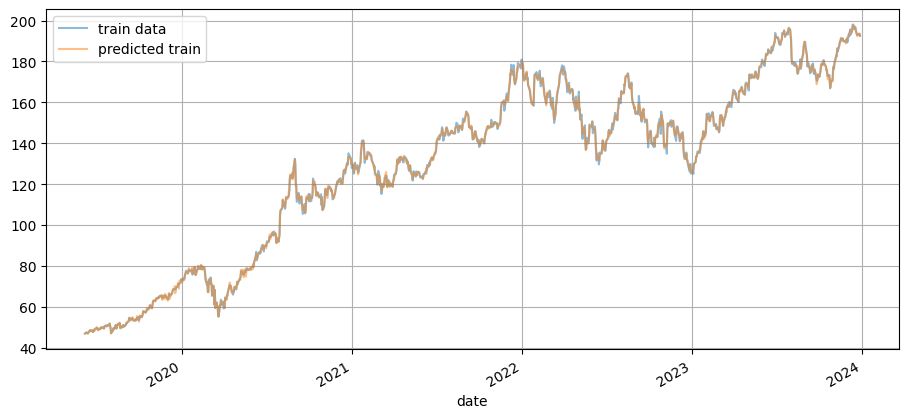

In [32]:
fig,ax = plt.subplots(figsize = (11,5))
predicted_train[['train data']].plot(ax=ax,alpha=.5)
predicted_train[['predicted train']].plot(ax=ax,alpha=.5,)
ax.grid()
ax.legend()

# тестируем

In [33]:
# (df_test_features.isnull().sum()==0).all()

In [34]:
predicted_test = target_test.to_frame()
x = poly.transform( df_test_features.values  )
predicted_test['predicted test'] = model.predict(x)
predicted_test = predicted_test.rename(columns={'values':'test data'})

ValueError: Input X contains infinity or a value too large for dtype('float64').

In [ ]:
fig,ax = plt.subplots(figsize = (11,5))
predicted_train[['train data']].plot(ax=ax,alpha=.5)
predicted_test[['test data']].plot(ax=ax,alpha=.5)

predicted_train[['predicted train']].plot(ax=ax,alpha=.5,)
predicted_test[['predicted test']].plot(ax=ax,alpha=.5,)

ax.grid()
ax.legend()

In [ ]:
from sklearn.metrics import mean_squared_error

display( mean_squared_error( predicted_train['train data'], predicted_train['predicted train']) )
display( mean_squared_error( predicted_test['test data'], predicted_test['predicted test']) )

---

In [ ]:
# # остатки
# err = predicted_test['test data']-predicted_test['predicted test']
# fig,ax = plt.subplots(2,1,figsize = (9,7))
# err.plot(ax=ax[0])
# ax[0].grid()
# plot_acf(err,ax=ax[1])
# plt.tight_layout()

In [ ]:
## авторегрессия

In [ ]:
# start = history_deep*71
# n_step = 2

# df_ = df.iloc[start:start+history_deep-1]
# df_.loc[:,'id'] = 0

# display(df.iloc[start+history_deep].name)

# index,predicted = [],[]

# for n in range(n_step):
#     x_ = tsfresh.extract_features(
#             df_.reset_index(), 
#             default_fc_parameters=feature_settings['values'],
#             column_id='id', 
#             column_sort='date',
#             column_value='values',
#             disable_progressbar=True,
#             impute_function=F.impute, 
#             show_warnings=False,
#             n_jobs=4,
#         )[feature_order]

#     predicted.append( model.predict( x_.values ).flatten()[0] )
#     # predicted.append( model.predict( poly.transform( x_.values ) ).flatten()[0] )
#     index.append( df.iloc[start+history_deep+n].name)
#     df_ = pd.concat([ df_, pd.DataFrame( { 'values':[predicted[-1]],'id':[0] }, index=[index[-1]] )] )[1:]
#     df_.index.name = 'date'

In [ ]:
# predicted_ = pd.DataFrame( {'valueфs':predicted},index=index )
# display( predicted_ )

In [ ]:
# started = df.iloc[start:start+history_deep]

# fig,ax = plt.subplots(figsize = (11,3))
# ax.plot(df.iloc[start-history_deep: start+history_deep+n_step*2 ]['values'], label = 'data', color = 'steelblue')
# ax.plot(started, label = 'started', color = 'green')
# ax.plot(predicted_['values'], label = 'predicted', color = 'red')
# ax.set_xlabel('Месяцы', )
# ax.legend(title = '', loc = 'upper left', )
# ax.grid()